# Principle of univariance

In [1]:
import dreye
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
sns.set_theme(
    style='ticks', 
    context='talk',
)

In [23]:
wls = np.arange(300, 651)

In [24]:
from dreye.datasets import load_granada

In [25]:
daylight_spectra = load_granada()

In [119]:
mean_daylight = daylight_spectra.groupby('wavelengths')['microspectralphotonflux'].mean()
mean_daylight = dreye.Spectrum(mean_daylight, units='uE', name='daylight')(wls) / 10

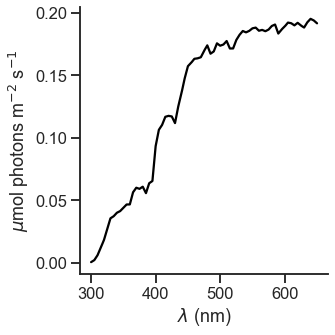

In [120]:
mean_daylight.plot(color='black')
plt.ylabel(r'$\mu$mol photons m$^{-2}$ s$^{-1}$')
plt.tight_layout()
plt.savefig('light_spectrum.pdf')

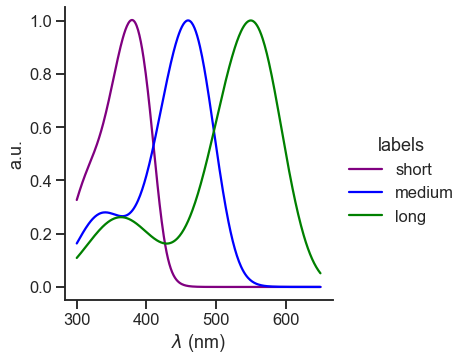

In [121]:
cmap = {'short': 'purple', 'medium': 'blue', 'long': 'green'}
peaks = np.array([380, 460, 550])
sensitivity1 = dreye.Sensitivity(
    peaks, 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='animal1'
)
sensitivity1.plot(palette=cmap)

In [122]:
pr_model1 = dreye.LinearPhotoreceptor(sensitivity1)

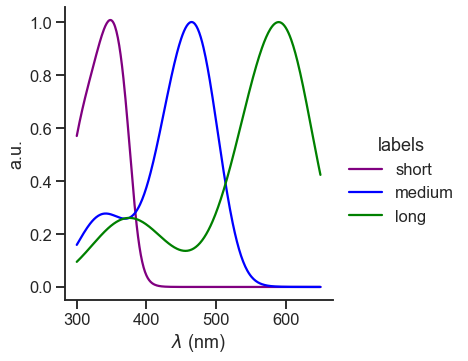

In [123]:
sensitivity2 = dreye.Sensitivity(
    peaks+np.array([-30, 5, +40]), 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='animal2'
)
sensitivity2.plot(palette=cmap)

In [124]:
pr_model2 = dreye.LinearPhotoreceptor(sensitivity2)

In [125]:
X1 = pr_model1.excitation(mean_daylight, return_units=False)
X2 = pr_model2.excitation(mean_daylight, return_units=False)

In [126]:
X1, X2

(array([[ 4.90478581, 14.6550887 , 22.76975458]]),
 array([[ 2.59286559, 15.22393248, 23.87260516]]))

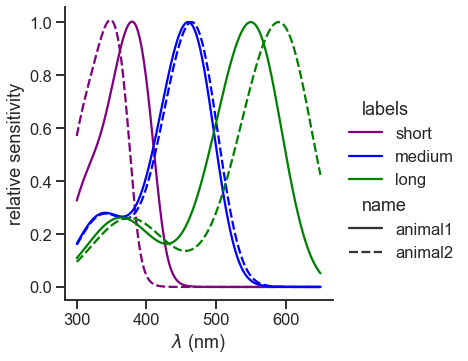

In [127]:
dreye.SignalsContainer([sensitivity1, sensitivity2]).plot(
    style='name', palette=cmap, hue='labels', col=None, 
    xlabel=r'$\lambda$ (nm)', 
    ylabel='relative sensitivity'
)
plt.savefig('sensitivities.pdf')

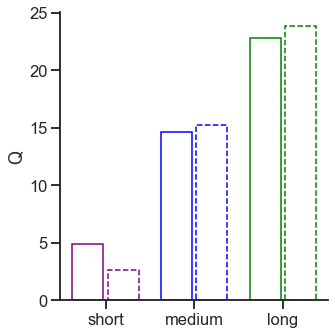

In [128]:
plt.figure(figsize=(5, 5))
plt.bar(np.arange(3)-0.2, X1[0], width=0.35, color='white', edgecolor=cmap.values())
plt.bar(np.arange(3)+0.2, X2[0], width=0.35, color='white', edgecolor=cmap.values(), linestyle='--')
plt.xticks(np.arange(3), cmap)
plt.ylabel('Q')
sns.despine()
plt.tight_layout()
plt.savefig('Q-daylight.pdf')

In [151]:
mpeaks = [340, 450, 560]
mnames = ['uv', 'cyan', 'lime']
mcolors = ['magenta', 'cyan', 'lime']
measured_spectra = dreye.create_led_spectra_container(mpeaks, names=mnames)

In [152]:
led_cmap = dict(zip(measured_spectra.names, mcolors))

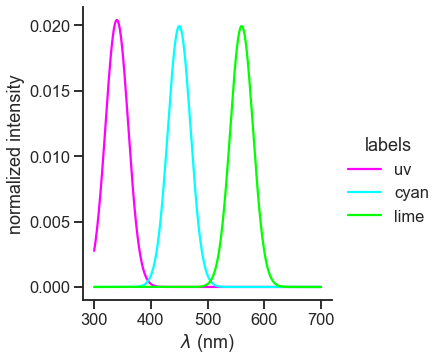

In [153]:
measured_spectra.normalized_spectra.plot(palette=led_cmap, ylabel='normalized intensity')
plt.savefig('LEDs.pdf')

In [132]:
model1 = dreye.IndependentExcitationFit(
    photoreceptor_model=pr_model1, 
    measured_spectra=measured_spectra, 
    ignore_bounds=True
)
model2 = dreye.IndependentExcitationFit(
    photoreceptor_model=pr_model2, 
    measured_spectra=measured_spectra, 
    ignore_bounds=True
)

In [133]:
model1.fit(X1)
model2.fit(X2)

IndependentExcitationFit(ignore_bounds=True,
                         measured_spectra=MeasuredSpectraContainer([[0.0 0.03069343368231487 0.06138686736462974 ... 0.2148540357762041  0.24554746945851896 0.2762409031408339] [0.0 0.032257037779231175 0.06451407555846235 ... 0.2257992644546182  0.2580563022338494 0.29031334001308057] [0.0 0.03387911490885154 0.06775822981770308 ... 0.2371538043619...61482574e-11 6.473295969167896e-11] [0.0 6.0435006255365266e-12 1.2087001251073053e-11 ...  4.230450437875568e-11 4.834800500429221e-11 5.439150562982874e-11] [0.0 5.074844671320177e-12 1.0149689342640355e-11 ...  3.5523912699241234e-11 4.059875737056142e-11 4.5673602041881596e-11]] microspectral_E_Q),
                         photoreceptor_model=LinearPhotoreceptor('short', 'medium', 'long'))

In [134]:
fitted_spectra1 = measured_spectra.ints_to_spectra(
    model1.fitted_intensities_
)
fitted_spectra1.name = 'animal1'
fitted_spectra2 = measured_spectra.ints_to_spectra(
    model2.fitted_intensities_
)
fitted_spectra2.name = 'animal2'

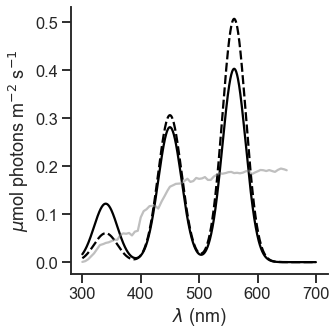

In [147]:
g = dreye.SignalsContainer([fitted_spectra1, fitted_spectra2]).plot(
    style='name', col=None, hue=None, color='black', 
    xlabel='$\lambda$ (nm)', 
    ylabel=r'$\mu$mol photons m$^{-2}$ s$^{-1}$', 
    legend=False
)
plt.plot(wls, mean_daylight.magnitude, color='gray', alpha=0.5)
plt.tight_layout()
plt.savefig('fitted_spectra.pdf')